<a href="https://colab.research.google.com/github/hyesungKomet/deep_learning/blob/main/ch4_CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 마운트

In [ ]:
%cd /content/drive/MyDrive/machine_learning

/content/drive/MyDrive/machine_learning


In [ ]:
%cd deep-learning-from-scratch-2

/content/drive/MyDrive/machine_learning/deep-learning-from-scratch-2


In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess
import numpy as np

In [ ]:
# embedding과 negativesampling계층 불러오기
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

## CBOW

In [ ]:
from common.layers import MatMul, SoftmaxWithLoss

In [ ]:
"""
class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    # corpus: word ID 목록 window_size: 맥락의 크기(주변의 몇개를 포함할지)
    V, H = vocab_size, hidden_size

    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V,H).astype('f') # float로 형 바꾸기 - 단어의 분산표현
    W_out = 0.01 * np.random.randn(V, H).astype('f') # 32비트 부동소수점 수로 초기화
    

    # 계층 생성
    self.in_layers = []
    for i in range(2 * window_size):
      layer = Embedding(W_in) # Embedding 계층 사용
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)


    # 가중치, 기울기 리스트에 담기
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산표현 저장
    self.word_vecs = W_in
    # 입력층의 가중치가 출력층 가중치보다 분산표현을 더 잘 표현함

  def forward(self, contexts, target): #contexts는 3차원, target은 2차원 배열로 가정
    h = 0
    for i, layer in enumerate(self.in_layers):
      h+= layer.forward(contexts[:, i])
    h *= 1/len(self.in_layers)
    
    loss = self.ns_loss.forward(h, target)
    return loss

  def backward(self, dout = 1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layer:
      layer.backward(dout)
    return None 
    # 이 경우에는 ch.3의 simple_cbow에서 원핫벡터로 나타낸 것과 다르게 word ID 그대로 썼다
    """

In [ ]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

## 옵티마이저 처리시 같은 가중치가 계속 쓰이기에 중복 제거해줌
매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.

## 학습

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common import config
config.GPU = False #cupy 설치 필요, GPU안쓰면 반나절은 걸림

import pickle

from common.trainer import Trainer
from common.optimizer import Adam

from common.util import create_contexts_target
from dataset import ptb


In [ ]:
import torch
print("cuda version: {}".format(torch.version.cuda))

cuda version: 10.2


In [ ]:
device = torch.device('cuda')

cpu_tensor = torch.zeros(2,3)
if torch.cuda.is_available():
  gpu_tensor = cpu_tensor.to(device)
  print(gpu_tensor)
  print(type(gpu_tensor))

tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')
<class 'torch.Tensor'>


In [ ]:
def to_cpu(x):
  cpu_tensor = x.to(torch.device('cpu'))
  return cpu_tensor

def to_gpu(x):
  if torch.cuda.is_available():
    gpu_tensor = x.to(device)
  return gpu_tensor


In [ ]:
print(type(contexts))

<class 'numpy.ndarray'>


# 하이퍼파라미터 설정

In [ ]:
window_size = 5 # 2~10 권장
hidden_size = 100 #50~500 권장
batch_size = 100
max_epoch = 10

# 데이터 읽기


In [ ]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU: # numpy를 torch로 형변환해주어야 한다
  gpu_contexts = torch.Tensor(contexts)
  gpu_target = torch.Tensor(target)
  gpu_contexts, gpu_target = to_gpu(gpu_contexts), to_gpu(gpu_target)
  print(type(gpu_contexts))

In [ ]:
#contexts = to_cpu(gpu_contexts).numpy() # 다시 numpy로 형변환
#target = to_cpu(gpu_target).numpy()
print(type(contexts))
print(contexts)

<class 'numpy.ndarray'>
[[   0    1    2 ...    8    9   10]
 [   1    2    3 ...    9   10   11]
 [   2    3    4 ...   10   11   12]
 ...
 [ 706 9999  119 ...  258   64   39]
 [9999  119 1143 ...   64   39   26]
 [ 119 1143   69 ...   39   26   24]]


# 모델 등 생성

In [ ]:
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [ ]:
#정수로 변환
#contexts = list(map(int, contexts))
#target = list(map(int, target))

# 학습 시작

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.04
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.91
| 에폭 1 |  반복 121 / 9295 | 시간 8[s] | 손실 3.76
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.61
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 12[s] | 손실 3.35
| 에폭 1 |  반복 201 / 9295 | 시간 13[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 16[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 17[s] | 손실 3.00
| 에폭 1 |  반복 281 / 9295 | 시간 18[s] | 손실 2.95
| 에폭 1 |  반복 301 / 9295 | 시간 20[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 21[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 22[s] | 손실 2.81
| 에폭 1 |  반복 361 / 9295 | 시간 23[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 25[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 26[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 27[s] | 손실 2.78
| 에폭 1 |  반복 441 / 9295 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

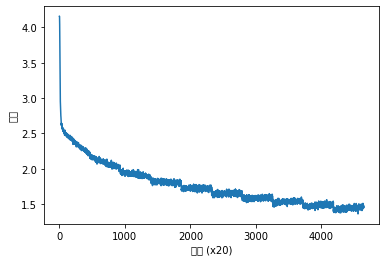

In [ ]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

## 학습 데이터 저장

In [ ]:
word_vecs = model.word_vecs #word_vecs에 W_in, 즉 단어의 분산표현 저장됨
if config.GPU:
  word_vecs = to_cpu(word_vecs)

#가중치, word:id 등을 파일에 저장
params = {}
params['word_vecs'] = word_vecs.astype(np.float64)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

# CBOW 모델 평가

In [ ]:
from common.util import most_similar

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)

In [ ]:
word_vecs = params['word_vecs']
word_to_id = params['word_to_id']
id_to_word = params['id_to_word']

In [ ]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.7650813719765195
 i: 0.7080636083942734
 your: 0.6237625498174161
 they: 0.6179439527585674
 anybody: 0.5676911455533565

[query] year
 month: 0.8432267433057774
 week: 0.7672271035239501
 summer: 0.7639591104385278
 spring: 0.7364119133696798
 decade: 0.7141634682947976

[query] car
 luxury: 0.6413147278605161
 auto: 0.6086105964253447
 cars: 0.5838250288918284
 truck: 0.5782490324912936
 merkur: 0.5695749888033786

[query] toyota
 nec: 0.6342441596208059
 tires: 0.6221208768198038
 seita: 0.6082399995743393
 coated: 0.6053988157219362
 motor: 0.5962017665776292


In [ ]:
from common.util import analogy

In [ ]:
analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs, top=5)


[analogy] man:king = woman:?
 horse: 4.0770765485218226
 hat: 3.9024804480585202
 c.d.s: 3.8197180140971545
 researcher: 3.6996509626429583
 artist: 3.676168189065522


In [ ]:
analogy('car', 'cars', 'chil', word_to_id, id_to_word, word_vecs, top=5)